In [ ]:
import yfinance as yf

# Download Reliance data from Yahoo Finance
reliance_data = yf.download('RELIANCE.NS', start='2020-01-01', end='2024-09-30')

# Save to CSV
reliance_data.to_csv('RELIANCE.NS_Historical_Data.csv')

[*********************100%***********************]  1 of 1 completed
ERROR:yfinance:
1 Failed download:
ERROR:yfinance:['NIFTY50']: YFTzMissingError('$%ticker%: possibly delisted; no timezone found')


In [ ]:
!pip install ta

import pandas as pd
import ta

# Load data
data = pd.read_csv('/content/RELIANCE.NS_Historical_Data.csv')

# Ensure the data is sorted by date
data['Date'] = pd.to_datetime(data['Date'])
data.sort_values('Date', inplace=True)

# Calculate RSI
data['RSI'] = ta.momentum.RSIIndicator(data['Close'], window=14).rsi()

# Save the updated DataFrame to a new CSV file
data.to_csv('/content/RELIANCE.NS_Historical_Data.csv', index=False)


EmptyDataError: No columns to parse from file

In [ ]:
import pandas as pd
import ta

# Load data
data = pd.read_csv('/content/RELIANCE.NS_Historical_Data.csv')

# Calculate MACD and Signal Line using the `ta` library
macd = ta.trend.MACD(data['Close'], window_slow=26, window_fast=12, window_sign=9)

# Add MACD Line, Signal Line, and MACD Histogram to the DataFrame
data['MACD_Line'] = macd.macd()  # The MACD Line
data['Signal_Line'] = macd.macd_signal()  # The Signal Line
data['MACD_Histogram'] = macd.macd_diff()  # The MACD Histogram (MACD Line - Signal Line)

# Save the DataFrame to a CSV file
output_file = '/content/RELIANCE_NSE_with_MACD.csv'
data.to_csv(output_file, index=False)

# Display the final DataFrame to verify
print(f"MACD data saved to {output_file}")
print(data[['Date', 'Close', 'MACD_Line', 'Signal_Line', 'MACD_Histogram']].tail())


MACD data saved to /content/RELIANCE_NSE_with_MACD.csv
            Date        Close  MACD_Line  Signal_Line  MACD_Histogram
1170  2024-09-23  2986.750000  -9.971836   -12.983774        3.011938
1171  2024-09-24  2978.750000  -7.579453   -11.902910        4.323456
1172  2024-09-25  2987.899902  -4.888797   -10.500087        5.611290
1173  2024-09-26  2995.899902  -2.086844    -8.817438        6.730595
1174  2024-09-27  3052.350098   4.635350    -6.126881       10.762231


In [ ]:
import pandas as pd

# Load the dataset
data = pd.read_csv('RELIANCE_NSE_with_MACD.csv', parse_dates=['Date'])
data.set_index('Date', inplace=True)

# Display the first few rows of the dataframe
print(data.head())


                   Open         High          Low        Close    Adj Close  \
Date                                                                          
2020-01-01  1387.957031  1396.277466  1376.527954  1380.276611  1356.042725   
2020-01-02  1382.471069  1408.941040  1382.471069  1403.775024  1379.128662   
2020-01-03  1401.671997  1409.581055  1392.528687  1405.466553  1380.790405   
2020-01-06  1389.785767  1397.008911  1369.670410  1372.870605  1348.766846   
2020-01-07  1388.871338  1403.043579  1383.842529  1393.991699  1369.517090   

              Volume  RSI  MACD_Line  Signal_Line  MACD_Histogram  
Date                                                               
2020-01-01   7002234  NaN        NaN          NaN             NaN  
2020-01-02   8855158  NaN        NaN          NaN             NaN  
2020-01-03  10492349  NaN        NaN          NaN             NaN  
2020-01-06  12259588  NaN        NaN          NaN             NaN  
2020-01-07   8341811  NaN        NaN  

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

# Load the dataset
data = pd.read_csv('RELIANCE_NSE_with_MACD.csv', parse_dates=['Date'])
data.set_index('Date', inplace=True)

# Remove the first 34 rows which contain NaN values
data = data.iloc[34:]

# Optionally, check if there are any more NaNs and handle them
print(data.isnull().sum())  # This will show the count of NaNs in each column

# If further handling is necessary, choose to fill NaNs (forward fill or backward fill)
# data.fillna(method='ffill', inplace=True)  # Forward fill
# data.fillna(method='bfill', inplace=True)  # Backward fill


Open              0
High              0
Low               0
Close             0
Adj Close         0
Volume            0
RSI               0
MACD_Line         0
Signal_Line       0
MACD_Histogram    0
dtype: int64


In [ ]:
# Normalizing RSI for use in imitation strength calculation
data['Normalized RSI'] = data['RSI'] / 100  # Normalized between 0 and 1

# Define a simple function to calculate imitation strength based on RSI
def calculate_imitation_strength(rsi):
    if rsi > 75:
        return (rsi - 70) / 30  # Scale: 0 to 1 as RSI goes from 70 to 100
    elif rsi < 25:
        return (30 - rsi) / 30  # Scale: 0 to 1 as RSI goes from 30 to 0
    else:
        return 0

# Apply the function across the RSI values
data['Imitation Strength'] = data['Normalized RSI'].apply(calculate_imitation_strength)


/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


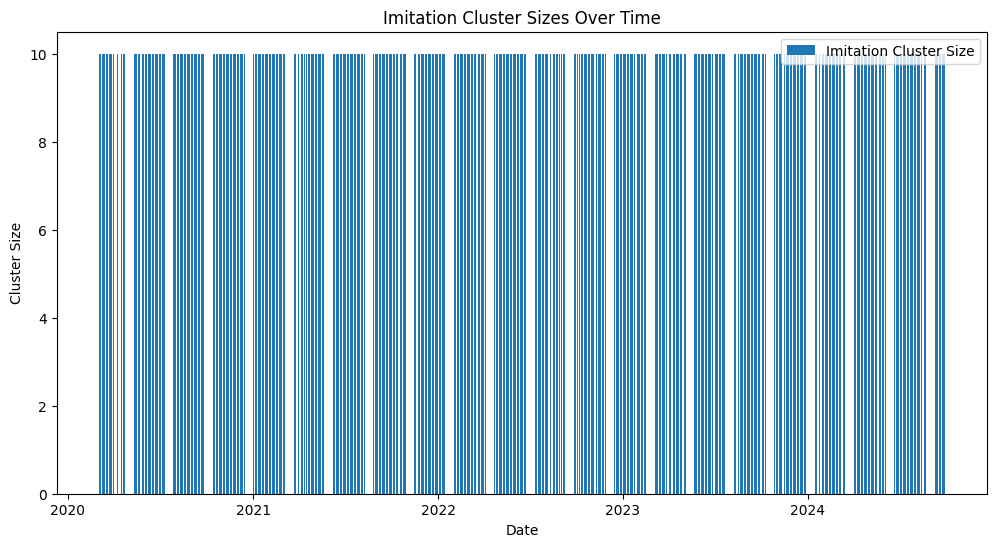

In [ ]:
# Identify high imitation strength
high_imitation_threshold = 0.7  # Define threshold, adjust based on analysis
data['High Imitation'] = (data['Imitation Strength'] > high_imitation_threshold).astype(int)

# Calculate clusters using a rolling sum
cluster_window = 10  # Days to look for clustering
data['Imitation Cluster Size'] = data['High Imitation'].rolling(window=cluster_window).sum()

# Visualize the clusters
plt.figure(figsize=(12, 6))
plt.bar(data.index, data['Imitation Cluster Size'], label='Imitation Cluster Size')
plt.title('Imitation Cluster Sizes Over Time')
plt.xlabel('Date')
plt.ylabel('Cluster Size')
plt.legend()
plt.show()


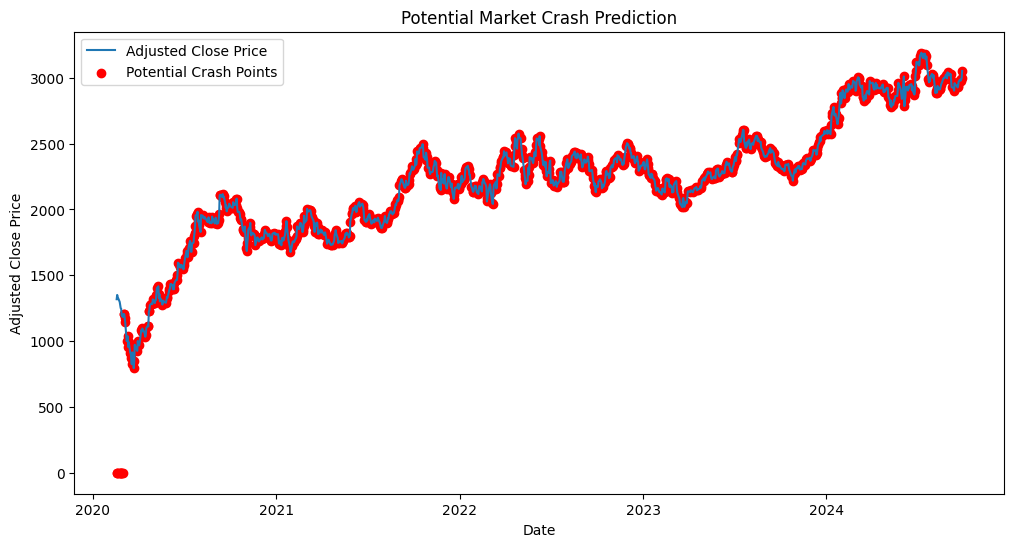

In [ ]:
# Define a critical cluster size based on historical data analysis
critical_cluster_size = 9
data['Potential Crash'] = (data['Imitation Cluster Size'] >= critical_cluster_size).astype(int)

# Visualizing potential crash points
plt.figure(figsize=(12, 6))
plt.plot(data['Adj Close'], label='Adjusted Close Price')
plt.scatter(data.index, data['Potential Crash'] * data['Adj Close'], color='red', label='Potential Crash Points')
plt.title('Potential Market Crash Prediction')
plt.xlabel('Date')
plt.ylabel('Adjusted Close Price')
plt.legend()
plt.show()


In [ ]:
  # Define imitation strength based on RSI and MACD signals
def calculate_imitation_strength(rsi, macd_histogram):
    k = 0
    if rsi > 70 or rsi < 30:  # Overbought or oversold conditions
        k += 0.5
    if macd_histogram > 0:  # Bullish signal
        k += 0.5
    elif macd_histogram < 0:  # Bearish signal
        k -= 0.5
    return k

data['Imitation Strength'] = data.apply(lambda row: calculate_imitation_strength(row['RSI'], row['MACD_Histogram']), axis=1)


In [ ]:
# Define clusters by rolling sum of high imitation strength points
critical_k = 0.4  # Define a threshold for what's considered high imitation
data['High Imitation'] = (data['Imitation Strength'] > critical_k).astype(int)
data['Cluster Size'] = data['High Imitation'].rolling(window=10).sum()  # 10-day window for cluster size


In [ ]:
import numpy as np
# Constants for the hazard rate calculation
C = 0.08  # This should be calibrated
delta = 2  # As delta > 1, this will create a super-exponential growth in hazard rate

# Calculate the hazard rate h(t) over time
data['Hazard Rate'] = C * np.power(data['Cluster Size'], delta)

# Set a hazard threshold to predict a crash
hazard_threshold = 4  # This threshold should be calibrated based on historical data
data['Predicted Crash'] = (data['Hazard Rate'] > hazard_threshold).astype(int)


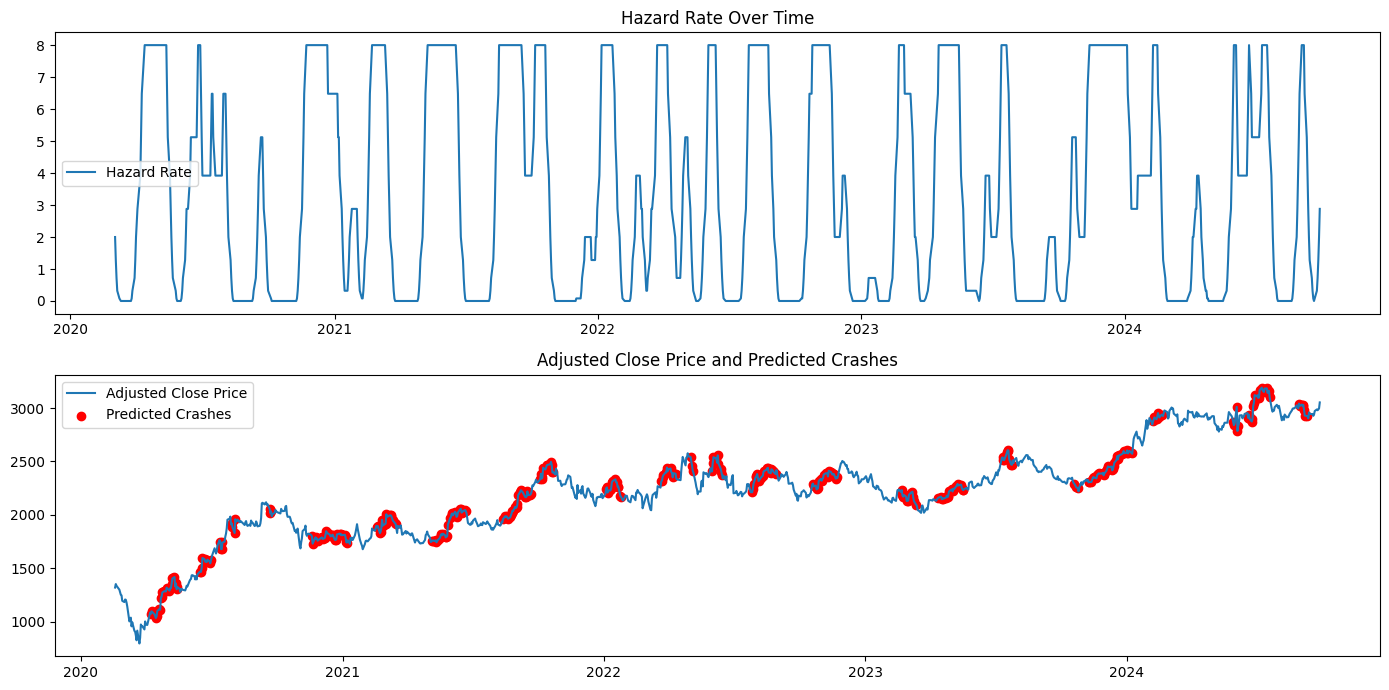

In [ ]:
# Plotting the hazard rate and crash predictions
plt.figure(figsize=(14, 7))
plt.subplot(211)
plt.plot(data['Hazard Rate'], label='Hazard Rate')
plt.title('Hazard Rate Over Time')
plt.legend()

plt.subplot(212)
plt.plot(data['Adj Close'], label='Adjusted Close Price')
plt.scatter(data.index[data['Predicted Crash'] == 1], data['Adj Close'][data['Predicted Crash'] == 1], color='red', label='Predicted Crashes')
plt.title('Adjusted Close Price and Predicted Crashes')
plt.legend()
plt.tight_layout()
plt.show()


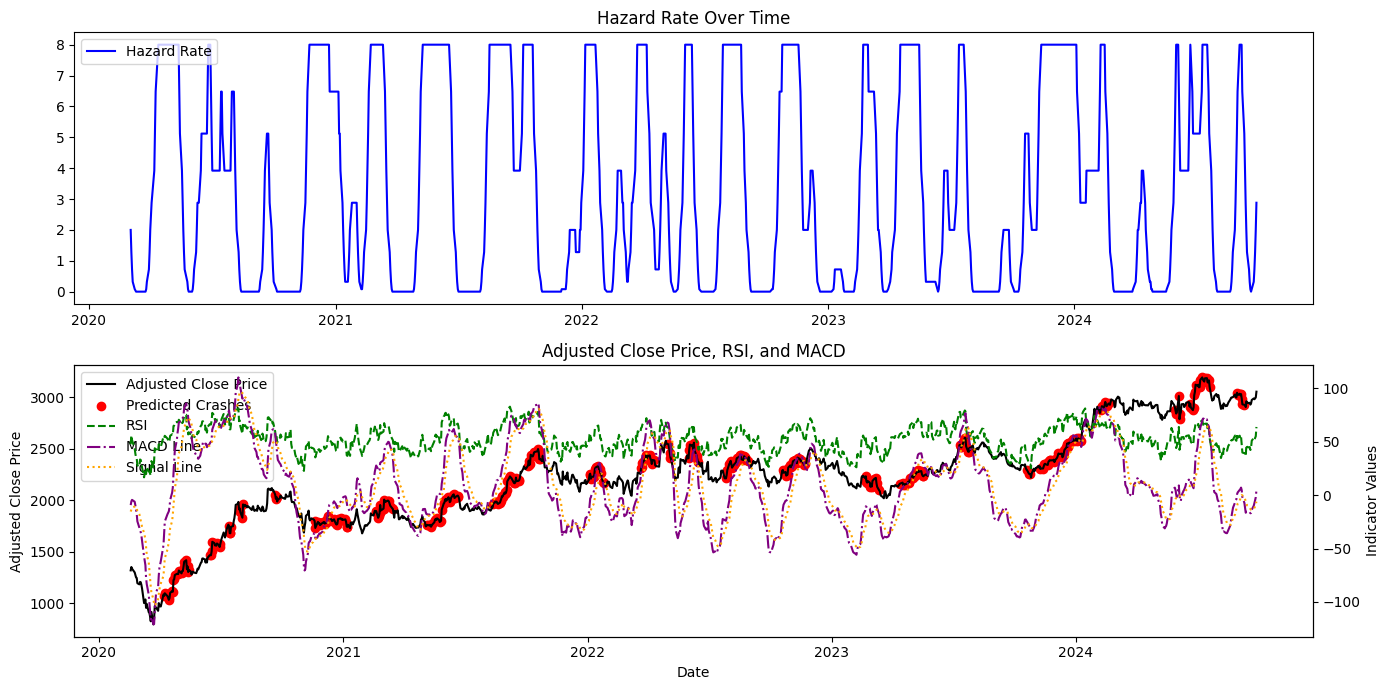

In [ ]:
import matplotlib.pyplot as plt

# Set up the figure and main plot for the adjusted close price
plt.figure(figsize=(14, 7))
ax1 = plt.subplot(211)  # Subplot for hazard rate
ax1.plot(data['Hazard Rate'], label='Hazard Rate', color='blue')
ax1.set_title('Hazard Rate Over Time')
ax1.legend(loc='upper left')

ax2 = plt.subplot(212)  # Subplot for adjusted close price and indicators
ax2.plot(data['Adj Close'], label='Adjusted Close Price', color='black')
ax2.scatter(data.index[data['Predicted Crash'] == 1], data['Adj Close'][data['Predicted Crash'] == 1], color='red', label='Predicted Crashes', marker='o')

# Create a secondary axis to plot RSI and MACD
ax3 = ax2.twinx()  # Create a twin of Axes for plotting RSI and MACD
ax3.plot(data['RSI'], label='RSI', color='green', linestyle='--')
ax3.plot(data['MACD_Line'], label='MACD Line', color='purple', linestyle='-.')
ax3.plot(data['Signal_Line'], label='Signal Line', color='orange', linestyle=':')

# Set labels and title for the plot
ax2.set_title('Adjusted Close Price, RSI, and MACD')
ax2.set_xlabel('Date')
ax2.set_ylabel('Adjusted Close Price')
ax3.set_ylabel('Indicator Values')

# Add legends
lines_1, labels_1 = ax2.get_legend_handles_labels()
lines_2, labels_2 = ax3.get_legend_handles_labels()
ax2.legend(lines_1 + lines_2, labels_1 + labels_2, loc='upper left')

plt.tight_layout()
plt.show()


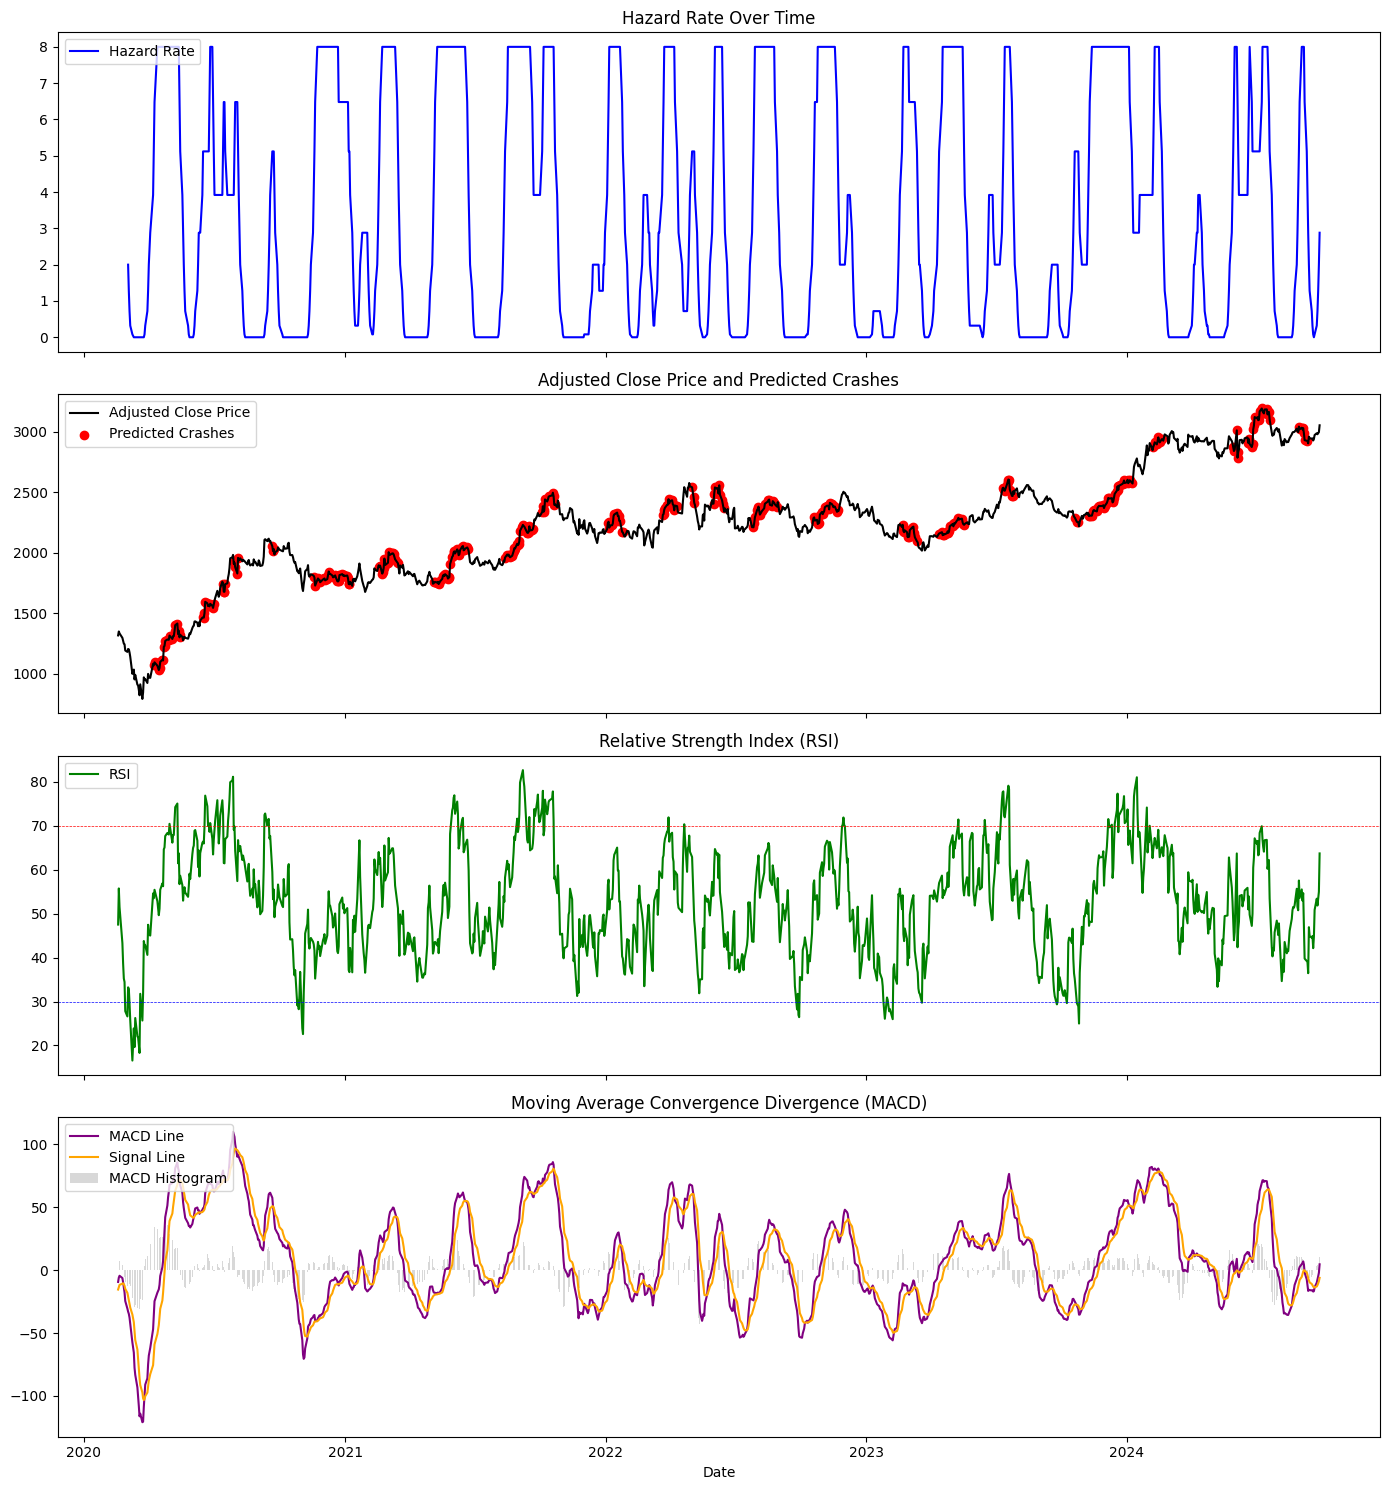

In [ ]:
import matplotlib.pyplot as plt

fig, (ax1, ax2, ax3, ax4) = plt.subplots(4, 1, figsize=(14, 15), sharex=True)

# Hazard Rate
ax1.plot(data['Hazard Rate'], label='Hazard Rate', color='blue')
ax1.set_title('Hazard Rate Over Time')
ax1.legend(loc='upper left')

# Adjusted Close Price with Crash Points
ax2.plot(data['Adj Close'], label='Adjusted Close Price', color='black')
ax2.scatter(data.index[data['Predicted Crash'] == 1], data['Adj Close'][data['Predicted Crash'] == 1], color='red', label='Predicted Crashes', marker='o')
ax2.set_title('Adjusted Close Price and Predicted Crashes')
ax2.legend(loc='upper left')

# RSI
ax3.plot(data['RSI'], label='RSI', color='green')
ax3.axhline(70, color='red', linestyle='--', linewidth=0.5)  # Overbought line
ax3.axhline(30, color='blue', linestyle='--', linewidth=0.5)  # Oversold line
ax3.set_title('Relative Strength Index (RSI)')
ax3.legend(loc='upper left')

# MACD with Signal Line
ax4.plot(data['MACD_Line'], label='MACD Line', color='purple')
ax4.plot(data['Signal_Line'], label='Signal Line', color='orange')
ax4.bar(data.index, data['MACD_Histogram'], color='gray', label='MACD Histogram', alpha=0.3)
ax4.set_title('Moving Average Convergence Divergence (MACD)')
ax4.legend(loc='upper left')

plt.xlabel('Date')
plt.tight_layout()
plt.show()


In [ ]:
!pip install plotly


In [ ]:
import numpy as np

def backtest(data, parameters):
    predictions = []
    for index, row in data.iterrows():
        hazard_rate = parameters['C'] * np.power(row['Cluster Size'], parameters['delta'])
        if hazard_rate > parameters['hazard_threshold']:
            predictions.append(1)  # Predict crash
        else:
            predictions.append(0)  # No crash predicted
    return predictions

# Define initial parameters
parameters = {'C': 0.01, 'delta': 1.5, 'hazard_threshold': 0.7}

# Historical data simulation
historical_data = data  # Your dataframe with historical data
predictions = backtest(historical_data, parameters)

# Evaluate predictions here (comparison with actual crash data)


In [ ]:
import pandas as pd
import numpy as np

# Assuming 'data' contains your stock data with 'Volume', 'Close', 'RSI', 'MACD_Line'

# Calculate On-Balance Volume
data['OBV'] = (np.sign(data['Close'].diff()) * data['Volume']).fillna(0).cumsum()

# Adjusting the imitation strength function to include OBV
def calculate_imitation_strength(rsi, macd_histogram, obv_change):
    k = 0
    threshold_obv = 10000  # Example threshold, adjust based on your data scaling
    if rsi > 70 or rsi < 30:
        k += 0.5
    if macd_histogram > 0:
        k += 0.5
    elif macd_histogram < 0:
        k -= 0.5
    if obv_change > threshold_obv:
        k += 0.5  # Increase imitation strength if OBV shows strong buying/selling pressure
    return k

# Calculate daily change in OBV to capture momentum
data['OBV Change'] = data['OBV'].diff()

# Apply the modified function
data['Imitation Strength'] = data.apply(lambda row: calculate_imitation_strength(row['RSI'], row['MACD_Histogram'], row['OBV Change']), axis=1)

# Continue with your existing model setup for clustering, hazard rate calculation, etc.


In [ ]:
import plotly.graph_objects as go
from plotly.subplots import make_subplots

# Extend the number of rows in make_subplots to 6 for the hazard rate
fig = make_subplots(rows=6, cols=1, shared_xaxes=True,
                    subplot_titles=('Adjusted Close Price', 'RSI', 'MACD Line and Signal Line',
                                    'MACD Histogram', 'On-Balance Volume', 'Hazard Rate Over Time'))

# Plot Adjusted Close Price
fig.add_trace(go.Scatter(x=data.index, y=data['Adj Close'], name='Adj Close'), row=1, col=1)
# Plot Hazard Rate
fig.add_trace(go.Scatter(x=data.index, y=data['Hazard Rate'], name='Hazard Rate', line=dict(color='red')), row=6, col=1)
# Plot RSI
fig.add_trace(go.Scatter(x=data.index, y=data['RSI'], name='RSI'), row=2, col=1)

# Plot MACD Line and Signal Line
fig.add_trace(go.Scatter(x=data.index, y=data['MACD_Line'], name='MACD Line'), row=3, col=1)
fig.add_trace(go.Scatter(x=data.index, y=data['Signal_Line'], name='Signal Line'), row=3, col=1)

# Plot MACD Histogram
fig.add_trace(go.Bar(x=data.index, y=data['MACD_Histogram'], name='MACD Histogram'), row=4, col=1)

# Plot OBV
fig.add_trace(go.Scatter(x=data.index, y=data['OBV'], name='OBV'), row=5, col=1)



# Update layout
fig.update_layout(height=1800, width=800, title_text="Comprehensive Stock Analysis with Interactive Features")
fig.show()




In [ ]:
import pandas as pd
import plotly.graph_objects as go
from plotly.subplots import make_subplots

# Ensure the 'Date' column is in datetime format
data['Date'] = pd.to_datetime(data.index)  # Ensure the 'Date' is in datetime format

# Filter the data between 2022 and 2024
data_filtered = data[(data['Date'] >= '2022-01-01') & (data['Date'] <= pd.Timestamp.now())]

# Create subplots with 6 rows for different indicators
fig = make_subplots(
    rows=6, cols=1, shared_xaxes=True,
    subplot_titles=(
        'Adjusted Close Price', 'RSI', 'MACD Line and Signal Line',
        'MACD Histogram', 'On-Balance Volume', 'Hazard Rate Over Time'
    )
)

# Plot Adjusted Close Price
fig.add_trace(go.Scatter(x=data_filtered.index, y=data_filtered['Adj Close'], name='Adj Close'), row=1, col=1)

# Plot Hazard Rate
fig.add_trace(go.Scatter(x=data_filtered.index, y=data_filtered['Hazard Rate'], name='Hazard Rate', line=dict(color='red')), row=6, col=1)

# Plot RSI
fig.add_trace(go.Scatter(x=data_filtered.index, y=data_filtered['RSI'], name='RSI'), row=2, col=1)

# Plot MACD Line and Signal Line
fig.add_trace(go.Scatter(x=data_filtered.index, y=data_filtered['MACD_Line'], name='MACD Line'), row=3, col=1)
fig.add_trace(go.Scatter(x=data_filtered.index, y=data_filtered['Signal_Line'], name='Signal Line'), row=3, col=1)

# Plot MACD Histogram
fig.add_trace(go.Bar(x=data_filtered.index, y=data_filtered['MACD_Histogram'], name='MACD Histogram'), row=4, col=1)

# Plot OBV
fig.add_trace(go.Scatter(x=data_filtered.index, y=data_filtered['OBV'], name='OBV'), row=5, col=1)

# Update layout
fig.update_layout(height=1800, width=800, title_text="Comprehensive Stock Analysis with Interactive Features (2022-2024)")
fig.show()


In [ ]:
# Constants and initial setup
delta = 1.5  # As an example, delta should be > 1 to cause a singularity
alpha = 1 / (delta - 1)  # Calculate alpha based on delta
B = 100  # Scaling factor, needs calibration

# Assume tc is the forecasted potential crash time, initialized here as a sample
# This could be derived from your models or set to a specific forecast horizon
data['t_c'] = pd.Timestamp('2024-12-31')  # Example critical time


In [ ]:
import pandas as pd
import numpy as np

# Ensure the 't_c' column and the index are in datetime format
# Example: converting both to datetime format if needed
data['t_c'] = pd.to_datetime(data['t_c'])
data['Date'] = pd.to_datetime(data.index)  # Assuming the index or a 'Date' column is a datetime

# Calculate time difference in days from 'tc'
data['Time to tc'] = (data['t_c'] - data['Date']).dt.days

# Constants for hazard rate calculation (B and alpha)
B = 1.0  # Example constant
alpha = 0.5  # Example power

# Calculate hazard rate using the finite-time singularity formula
data['Hazard Rate'] = B / np.power(data['Time to tc'], alpha)

# Display the result
print(data[['Date', 't_c', 'Time to tc', 'Hazard Rate']].tail())


                 Date        t_c  Time to tc  Hazard Rate
Date                                                     
2024-09-23 2024-09-23 2024-12-31          99     0.100504
2024-09-24 2024-09-24 2024-12-31          98     0.101015
2024-09-25 2024-09-25 2024-12-31          97     0.101535
2024-09-26 2024-09-26 2024-12-31          96     0.102062
2024-09-27 2024-09-27 2024-12-31          95     0.102598


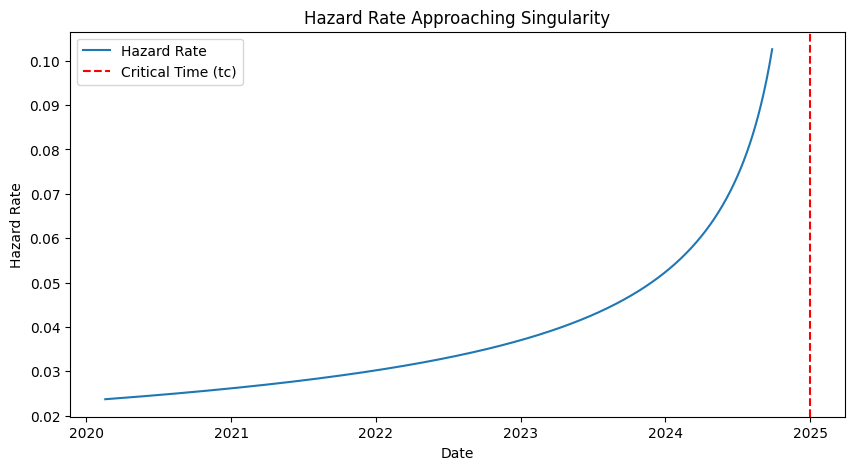

In [ ]:
import matplotlib.pyplot as plt

# Ensure t_c is a scalar datetime value, not a series
# Example: Set t_c as the end of your data period or a specific forecasted date
t_c = pd.Timestamp('2024-12-31')

plt.figure(figsize=(10, 5))
plt.plot(data.index, data['Hazard Rate'], label='Hazard Rate')
plt.axvline(x=t_c, color='r', linestyle='--', label='Critical Time (tc)')
plt.title('Hazard Rate Approaching Singularity')
plt.xlabel('Date')
plt.ylabel('Hazard Rate')
plt.legend()
plt.show()
